#### *1. benchmark of KPM to exact results of BCS sSC*

In [1]:
%reset -f
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib widget

from kpm import kpm, kpmBdG
import vegas

def construct_hamil(L, t, delta):
    N = L**2

    # construct the BdG hamiltonian
    row_indices = []
    col_indices = []
    data = []

    for i in range(N):
        x, y = i%L, i//L
        xp1, yp1 = ((x+1)%L) + y*L, x + ((y+1)%L)*L

        # particle and hole sector
        for s in (0,1):
            row_indices.append(i+s*N)
            col_indices.append(xp1+s*N)
            data.append(-(1-2*s)*t)
            row_indices.append(xp1+s*N)
            col_indices.append(i+s*N)
            data.append(-(1-2*s)*t)

            row_indices.append(i+s*N)
            col_indices.append(yp1+s*N)
            data.append(-(1-2*s)*t)
            row_indices.append(yp1+s*N)
            col_indices.append(i+s*N)
            data.append(-(1-2*s)*t)

        row_indices.append(i)
        col_indices.append(i+N)
        data.append(delta)
        row_indices.append(i+N)
        col_indices.append(i)
        data.append(np.conj(delta))

    sH = sparse.coo_matrix((data, (row_indices, col_indices)), shape=(2*N, 2*N), dtype=np.complex128).tocsr()
    sH.eliminate_zeros()
    return sH

# exact local Green's function of s-wave BCS
class cal_gf_bcs:
    def __init__(self, freq, t, delta, eta, type='normal'):
        assert type in ('normal', 'anomalous')
        self.type = type
        self.freq = freq
        self.t = t
        self.delta = delta
        self.eta = eta
        self.dim = 2

    def integrand(self, vars):
        x1, x2 = vars
        kx = np.pi * x1
        ky = np.pi * x2
        jacobian_kx = np.pi
        jacobian_ky = np.pi

        dispersion = - 2*self.t * (np.cos(kx) + np.cos(ky))
        gf = 1 / (self.freq+1j*self.eta - dispersion - self.delta*np.conj(self.delta)/(self.freq+1j*self.eta + dispersion))
        if self.type == 'anomalous':
            gf *= self.delta / (self.freq+1j*self.eta + dispersion)
        factor = jacobian_kx * jacobian_ky * 4 / (2*np.pi)**2
        return [factor*np.real(gf), factor*np.imag(gf)]

##### *1.1. local normal correlator*

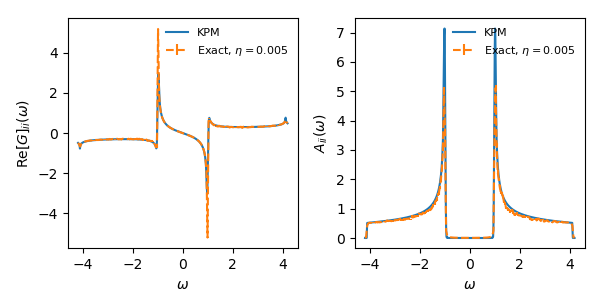

In [2]:
L = 512
t = 1.
delta = np.exp(1j*.25*np.pi) # arbitrary phase angle
sH = construct_hamil(L, t, delta)

scale = 4*t * 1.05
mus = kpmBdG.correlator(sH/scale, i=0, j=0, n=500, type='11')
xs, ys = kpmBdG.generate_profile(mus, nx=1000, kernel='jackson')
    
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(3*2,3))
ax1.plot(xs*scale, np.real(ys)/scale, label='KPM')
ax2.plot(xs*scale, -2*np.imag(ys)/scale, label='KPM')

freqs = np.linspace(-4*t, 4*t, 200, endpoint=True)
freqs *= 1.05
eta = 5e-3
gf = []
for freq in freqs:
    f = cal_gf_bcs(freq, t, delta, eta=eta, type='normal')
    integ = vegas.Integrator([[0,1]]*f.dim, nproc=1, mpi=True)
    f_call = lambda vars: f.integrand(vars)
    _ = integ(f_call, nitn=20, neval=1000) # training
    result = integ(f_call, nitn=20, neval=1000)
    gf.append((result[0].mean+1j*result[1].mean, result[0].sdev+1j*result[1].sdev))

gf_mean, gf_std = zip(*gf)
ax1.errorbar(freqs, np.real(gf_mean), np.real(gf_std), linestyle='dashed', label=f'Exact, $\\eta={eta:.3f}$')
ax2.errorbar(freqs, -2*np.imag(gf_mean), 2*np.imag(gf_std), linestyle='dashed', label=f'Exact, $\\eta={eta:.3f}$')

# # diagonalization
# xs = np.linspace(-4*t, 4*t, 50, endpoint=True)
# H = sH.todense()
# gfs = [np.linalg.inv((x+1j*1e-1)*np.eye(2*N) - H)[0,0] for x in xs]
# ys = -2*np.imag(gfs)
# ax2.plot(xs, ys)

ax1.set_xlabel(r'$\omega$')
ax2.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$\text{Re}[G]_{ii}(\omega)$')
ax2.set_ylabel(r'$A_{ii}(\omega)$')
ax1.legend(loc='best', frameon=False, prop={'size':8})
ax2.legend(loc='best', frameon=False, prop={'size':8})
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
fig.tight_layout()

##### *1.2. local anomalous correlator*

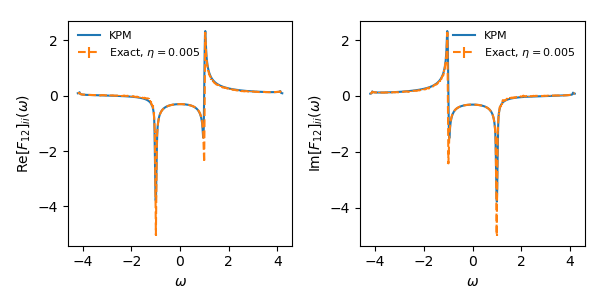

In [3]:
L = 512
t = 1.
delta = np.exp(1j*.25*np.pi) # arbitrary phase angle
sH = construct_hamil(L, t, delta)

scale = 4*t * 1.05
mus = kpmBdG.correlator(sH/scale, i=0, j=0, n=500, type='12')
xs, ys = kpmBdG.generate_profile(mus, nx=1000, kernel='jackson')
    
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(3*2,3))
ax1.plot(xs*scale, np.real(ys)/scale, label='KPM')
ax2.plot(xs*scale, np.imag(ys)/scale, label='KPM')

freqs = np.linspace(-4*t, 4*t, 200, endpoint=True)
freqs *= 1.05
eta = 5e-3
gf = []
for freq in freqs:
    f = cal_gf_bcs(freq, t, delta, eta=eta, type='anomalous')
    integ = vegas.Integrator([[0,1]]*f.dim, nproc=1, mpi=True)
    f_call = lambda vars: f.integrand(vars)
    _ = integ(f_call, nitn=20, neval=1000) # training
    result = integ(f_call, nitn=20, neval=1000)
    gf.append((result[0].mean+1j*result[1].mean, result[0].sdev+1j*result[1].sdev))

gf_mean, gf_std = zip(*gf)
ax1.errorbar(freqs, np.real(gf_mean), np.real(gf_std), linestyle='dashed', label=f'Exact, $\\eta={eta:.3f}$')
ax2.errorbar(freqs, np.imag(gf_mean), np.imag(gf_std), linestyle='dashed', label=f'Exact, $\\eta={eta:.3f}$')

ax1.set_xlabel(r'$\omega$')
ax2.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$\text{Re}[F_{12}]_{ii}(\omega)$')
ax2.set_ylabel(r'$\text{Im}[F_{12}]_{ii}(\omega)$')
ax1.legend(loc='best', frameon=False, prop={'size':8})
ax2.legend(loc='best', frameon=False, prop={'size':8})
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
fig.tight_layout()

##### *1.3. local two-particle spin correlator*